# Import and settings

In [66]:
import torch #基本モジュール
from torch.autograd import Variable #自動微分用
import torch.nn as nn #ネットワーク構築用
import torch.optim as optim #最適化関数
import torch.nn.functional as F #ネットワーク用の様々な関数
import torch.utils.data #データセット読み込み関連
import torchvision #画像関連
from torchvision import datasets, models, transforms #画像用データセット諸々

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split, StratifiedKFold

from tqdm import tqdm

import logging
import logzero
from logzero import logger


# examination settings
batch_size = 128
test_batch_size = batch_size * 2
epochs = 1000
lr = 0.5
momentum = 0.9
seed = 2017
log_interval = 1000
num_workers = 2
use_gpu = False
ex_name = 'pseudo'

# set seed for reproducibility
torch.manual_seed(seed)
np.random.seed(seed)

# logger setting
LOG_FORMAT = '[%(asctime)s %(levelname)s] %(message)s'
logzero.loglevel(logging.INFO)
logzero.logfile('./log/{}.log'.format(ex_name))
logzero.formatter(logging.Formatter(LOG_FORMAT))

# Prepare data

In [2]:
train_dataset = datasets.MNIST('./data/MNIST/train/', download=True, train=True)
test_dataset = datasets.MNIST('./data/MNIST/test/', download=True, train=False)

train_data = train_dataset.train_data.numpy()
test_data = test_dataset.test_data.numpy()
train_labels = train_dataset.train_labels.numpy()
test_labels = test_dataset.test_labels.numpy()

In [3]:
print(len(train_labels), len(test_labels))

60000 10000


## Change the ratio train/test
train:val:test を 800:200:69000に設定。各クラスのサンプル数は均一に。testセットは実際に教師なし学習に用いることは想定しづらいので、現実のタスクや論文に書く時はunlabeledデータとして説明すれば良い。その場合はtestセット内で更に unlabeled/holdout に分ける必要がある。
交差検証は行わない。

pseudo label実験に対してはtestデータはunlabeledデータ及び最終評価用のデータとして使われる。valは学習中の精度監視用。

In [57]:
n_train = 1000
n_val = 1000
n_test = 68000

X_train = np.empty(shape=(0, 28, 28))
y_train = np.empty(shape=(0,))
X_val = np.empty(shape=(0, 28, 28))
y_val = np.empty(shape=(0,))
X_test = np.empty(shape=(0, 28, 28))
y_test = np.empty(shape=(0,))

for i in range(10):
    idx_train = np.argwhere(train_labels == i)[:(n_train//10)].squeeze()
    idx_val = np.argwhere(train_labels == i)[(n_train//10):((n_train+n_val)//10)].squeeze()
    idx_test = np.argwhere(train_labels == i)[((n_train+n_val)//10):].squeeze()
    
    X_train = np.concatenate([X_train, train_data[idx_train]], axis=0)
    y_train = np.concatenate([y_train, train_labels[idx_train]], axis=0)
    X_val = np.concatenate([X_val, train_data[idx_val]], axis=0)
    y_val = np.concatenate([y_val, train_labels[idx_val]], axis=0)
    X_test = np.concatenate([X_test, train_data[idx_test]], axis=0)
    y_test = np.concatenate([y_test, train_labels[idx_test]], axis=0)
    
X_test = np.concatenate([X_test, test_data], axis=0)
y_test = np.concatenate([y_test, test_labels], axis=0)

# treat as image
X_train = np.expand_dims(X_train, -1)
X_val = np.expand_dims(X_val, -1)
X_test = np.expand_dims(X_test, -1)

# one-hot encoding
lb = LabelBinarizer()
y_train = lb.fit_transform(y_train)
y_val = lb.transform(y_val)
y_test = lb.transform(y_test)

print(X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape)

(1000, 28, 28, 1) (1000, 10) (1000, 28, 28, 1) (1000, 10) (68000, 28, 28, 1) (68000, 10)


## Prepare Pseudo Label

testデータをtest/unlabeledに分ける。
比率は10000:58000とする。（元々のMNISTの提供時点でのtest splitを用いる）

In [64]:
y_pseudo = np.load('./save/pseudo_label.npy')

X_unlabeled = X_test[:58000]
y_unlabeled = y_test[:58000]
y_pseudo = y_pseudo[:58000]
X_test = X_test[58000:]
y_test = y_test[58000:]

print(X_unlabeled.shape, y_unlabeled.shape, y_pseudo.shape, X_test.shape, y_test.shape)

(10000, 28, 28, 1) (10000, 10) (58000, 10) (0, 28, 28, 1) (0, 10)


# Define a network

In [65]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(16)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(32)
        self.fc = nn.Linear(32, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.bn1(self.conv1(x)), 2))
        x = F.relu(F.max_pool2d(self.bn2(self.conv2(x)), 2))
        x = F.adaptive_max_pool2d(x, output_size=1)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        x = F.log_softmax(x)
        return x

# Define Dataset, DataLoader

In [7]:
class MNISTDataset(torch.utils.data.Dataset):
    def __init__(self, X, y, transform):
        self.X = X
        self.y = y
        self.transform = transform
        
    def __getitem__(self, index):
        img = self.X[index]
        img = self.transform(img)
        target = torch.Tensor(self.y[index].astype(float))
        return img, target
    
    def __len__(self):
        return self.X.shape[0]


class MNISTDatasetForPseudoLabeling(torch.utils.data.Dataset):
    def __init__(self, X_train, y_train, X_dash, Y_dash, transform):
        self.X = X
        self.y = y
        self.transform = transform
        
    def __getitem__(self, index):
        img = self.X[index]
        img = self.transform(img)
        target = torch.Tensor(self.y[index].astype(float))
        return img, target
    
    def __len__(self):
        return self.X.shape[0]

    
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

train_dataset = MNISTDataset(X_train, y_train, transform)
train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, num_workers=num_workers, shuffle=True)
val_dataset = MNISTDataset(X_val, y_val, transform)
val_loader = torch.utils.data.DataLoader(
    val_dataset, batch_size=test_batch_size, num_workers=num_workers)
test_dataset = MNISTDataset(X_test, y_test, transform)
test_loader = torch.utils.data.DataLoader(
    test_dataset, batch_size=test_batch_size, num_workers=num_workers)

# Define TrainingTracker

In [8]:
class TrainingTracker(object):
    def __init__(self):
        self.epoch = 0
        self.history = {
            'train_acc': [], 'train_loss': [], 'val_acc': [], 'val_loss': []
        }
        self.reset()
        
    def reset(self):
        self.train_acc = 0
        self.train_loss = 0
        self.val_acc = 0
        self.val_loss = 0
        self.train_count = 0
        self.val_count = 0

    def update(self, train, acc, loss, n):
        if train:
            acc_sum = self.train_acc * self.train_count + acc * n
            loss_sum = self.train_loss * self.train_count + loss * n
            self.train_count += n
            self.train_acc = acc_sum / self.train_count
            self.train_loss = loss_sum / self.train_count
        else:
            acc_sum = self.val_acc * self.val_count + acc * n
            loss_sum = self.val_loss * self.val_count + loss * n
            self.val_count += n
            self.val_acc = acc_sum / self.val_count
            self.val_loss = loss_sum / self.val_count

    def plot_history(self):
        plt.plot(self.history['train_acc'])
        plt.plot(self.history['val_acc'])
        plt.title('model accuracy')
        plt.xlabel('epoch')
        plt.ylabel('accuracy')
        plt.legend(['train_acc', 'val_acc'], loc='lower right')
        plt.show()

        plt.plot(self.history['train_loss'])
        plt.plot(self.history['val_loss'])
        plt.title('model loss')
        plt.xlabel('epoch')
        plt.ylabel('loss')
        plt.legend(['train_loss', 'val_loss'], loc='lower right')
        plt.show()

# Define train, validate, test function

In [12]:
def _train(model, data_loader, criterion, optimizer, tracker):
    model.train()
    for i, (X, y) in enumerate(data_loader):
        if use_gpu:
            X, y = X.cuda(), y.cuda()
        X, y = Variable(X), Variable(y)
        
        output = model(X)
        loss = criterion(output, y)
        pred = output.data.max(1)[1]
        answer = y.data.max(1)[1]
        acc = pred.eq(answer).sum() / len(X)
        tracker.update(train=True, acc=acc, loss=loss.data[0], n=len(X))
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    logger.info(
        'Epoch: {tracker.epoch} | '
        'TrainAcc: {tracker.train_acc:.4f} | '
        'TrainLoss: {tracker.train_loss:.4f}'.format(
            tracker=tracker)
    )
    tracker.history['train_acc'].append(tracker.train_acc)
    tracker.history['train_loss'] .append(tracker.train_loss)
    tracker.reset()

def _validate(model, data_loader, criterion, tracker):
    model.eval()
    for i, (X, y) in enumerate(data_loader):
        if use_gpu:
            X, y = X.cuda(), y.cuda()
        X, y = Variable(X), Variable(y)
        
        output = model(X)
        loss = criterion(output, y)
        pred = output.data.max(1)[1]
        answer = y.data.max(1)[1]
        acc = pred.eq(answer).sum() / len(X)
        tracker.update(train=False, acc=acc, loss=loss.data[0], n=len(X))

    logger.info(
        'Epoch: {tracker.epoch} | '
        'ValAcc: {tracker.val_acc:.4f} | '
        'ValLoss: {tracker.val_loss:.4f} \n'.format(
            tracker=tracker)
    )
    tracker.history['val_acc'].append(tracker.val_acc)
    tracker.history['val_loss'].append(tracker.val_loss)
    tracker.reset()
    
def _test(model, data_loader, criterion, make_pl=False):
    model.eval()
    
    if make_pl:
        pseudo_label = np.empty((0, 10))
    
    acc_sum = 0
    loss_sum = 0
    for i, (X, y) in tqdm(enumerate(data_loader), total=len(data_loader)):
        if use_gpu:
            X, y = X.cuda(), y.cuda()
        X, y = Variable(X), Variable(y)
        
        output = model(X)
        loss = criterion(output, y)
        pred = output.data.max(1)[1]
        answer = y.data.max(1)[1]
        acc_sum += pred.eq(answer).sum()
        loss_sum += loss.data[0] * X.size(0)
        
        if make_pl:
            pseudo_label = np.concatenate([pseudo_label, output.data.numpy()], axis=0)

    acc = acc_sum / n_test
    loss = loss_sum / n_test
    logger.info(
        'TestAcc: {0:.4f} | '
        'TestLoss: {1:.4f} '.format(
            acc, loss)
    )
    
    if make_pl:
        np.save('./save/pseudo_label_{}.npy'.format(ex_name), pseudo_label)

# Do training

[2017-12-02 18:02:35,389 INFO] Epoch: 0 | TrainAcc: 0.1380 | TrainLoss: 0.2344
[2017-12-02 18:02:35,826 INFO] Epoch: 0 | ValAcc: 0.2230 | ValLoss: 0.2284 

[2017-12-02 18:02:36,624 INFO] Epoch: 1 | TrainAcc: 0.2480 | TrainLoss: 0.2096
[2017-12-02 18:02:36,999 INFO] Epoch: 1 | ValAcc: 0.3580 | ValLoss: 0.2156 

[2017-12-02 18:02:37,756 INFO] Epoch: 2 | TrainAcc: 0.4380 | TrainLoss: 0.1796
[2017-12-02 18:02:38,115 INFO] Epoch: 2 | ValAcc: 0.5270 | ValLoss: 0.1742 

[2017-12-02 18:02:38,852 INFO] Epoch: 3 | TrainAcc: 0.5530 | TrainLoss: 0.1407
[2017-12-02 18:02:39,205 INFO] Epoch: 3 | ValAcc: 0.4420 | ValLoss: 0.1626 

[2017-12-02 18:02:39,974 INFO] Epoch: 4 | TrainAcc: 0.6800 | TrainLoss: 0.1039
[2017-12-02 18:02:40,351 INFO] Epoch: 4 | ValAcc: 0.4330 | ValLoss: 0.1578 

[2017-12-02 18:02:41,092 INFO] Epoch: 5 | TrainAcc: 0.7120 | TrainLoss: 0.0870
[2017-12-02 18:02:41,535 INFO] Epoch: 5 | ValAcc: 0.6110 | ValLoss: 0.1095 

[2017-12-02 18:02:42,324 INFO] Epoch: 6 | TrainAcc: 0.7830 | Tra

[2017-12-02 18:03:34,088 INFO] Epoch: 52 | TrainAcc: 1.0000 | TrainLoss: 0.0002
[2017-12-02 18:03:34,417 INFO] Epoch: 52 | ValAcc: 0.8960 | ValLoss: 0.0430 

[2017-12-02 18:03:35,072 INFO] Epoch: 53 | TrainAcc: 1.0000 | TrainLoss: 0.0002
[2017-12-02 18:03:35,405 INFO] Epoch: 53 | ValAcc: 0.8950 | ValLoss: 0.0432 

[2017-12-02 18:03:36,052 INFO] Epoch: 54 | TrainAcc: 1.0000 | TrainLoss: 0.0002
[2017-12-02 18:03:36,424 INFO] Epoch: 54 | ValAcc: 0.8970 | ValLoss: 0.0434 

[2017-12-02 18:03:37,091 INFO] Epoch: 55 | TrainAcc: 1.0000 | TrainLoss: 0.0002
[2017-12-02 18:03:37,417 INFO] Epoch: 55 | ValAcc: 0.8950 | ValLoss: 0.0431 

[2017-12-02 18:03:38,072 INFO] Epoch: 56 | TrainAcc: 1.0000 | TrainLoss: 0.0002
[2017-12-02 18:03:38,399 INFO] Epoch: 56 | ValAcc: 0.8970 | ValLoss: 0.0436 

[2017-12-02 18:03:39,053 INFO] Epoch: 57 | TrainAcc: 1.0000 | TrainLoss: 0.0002
[2017-12-02 18:03:39,386 INFO] Epoch: 57 | ValAcc: 0.8960 | ValLoss: 0.0439 

[2017-12-02 18:03:40,061 INFO] Epoch: 58 | TrainAcc:

[2017-12-02 18:04:25,493 INFO] Epoch: 104 | TrainAcc: 1.0000 | TrainLoss: 0.0001
[2017-12-02 18:04:25,814 INFO] Epoch: 104 | ValAcc: 0.8970 | ValLoss: 0.0456 

[2017-12-02 18:04:26,477 INFO] Epoch: 105 | TrainAcc: 1.0000 | TrainLoss: 0.0001
[2017-12-02 18:04:26,798 INFO] Epoch: 105 | ValAcc: 0.8970 | ValLoss: 0.0454 

[2017-12-02 18:04:27,459 INFO] Epoch: 106 | TrainAcc: 1.0000 | TrainLoss: 0.0001
[2017-12-02 18:04:27,782 INFO] Epoch: 106 | ValAcc: 0.8970 | ValLoss: 0.0460 

[2017-12-02 18:04:28,444 INFO] Epoch: 107 | TrainAcc: 1.0000 | TrainLoss: 0.0001
[2017-12-02 18:04:28,764 INFO] Epoch: 107 | ValAcc: 0.8980 | ValLoss: 0.0458 

[2017-12-02 18:04:29,421 INFO] Epoch: 108 | TrainAcc: 1.0000 | TrainLoss: 0.0001
[2017-12-02 18:04:29,743 INFO] Epoch: 108 | ValAcc: 0.8990 | ValLoss: 0.0457 

[2017-12-02 18:04:30,409 INFO] Epoch: 109 | TrainAcc: 1.0000 | TrainLoss: 0.0001
[2017-12-02 18:04:30,744 INFO] Epoch: 109 | ValAcc: 0.8960 | ValLoss: 0.0457 

[2017-12-02 18:04:31,396 INFO] Epoch: 11

[2017-12-02 18:05:15,964 INFO] Epoch: 155 | ValAcc: 0.8970 | ValLoss: 0.0468 

[2017-12-02 18:05:16,630 INFO] Epoch: 156 | TrainAcc: 1.0000 | TrainLoss: 0.0001
[2017-12-02 18:05:16,949 INFO] Epoch: 156 | ValAcc: 0.8970 | ValLoss: 0.0469 

[2017-12-02 18:05:17,603 INFO] Epoch: 157 | TrainAcc: 1.0000 | TrainLoss: 0.0001
[2017-12-02 18:05:17,922 INFO] Epoch: 157 | ValAcc: 0.8970 | ValLoss: 0.0470 

[2017-12-02 18:05:18,578 INFO] Epoch: 158 | TrainAcc: 1.0000 | TrainLoss: 0.0001
[2017-12-02 18:05:18,902 INFO] Epoch: 158 | ValAcc: 0.8980 | ValLoss: 0.0470 

[2017-12-02 18:05:19,557 INFO] Epoch: 159 | TrainAcc: 1.0000 | TrainLoss: 0.0001
[2017-12-02 18:05:19,883 INFO] Epoch: 159 | ValAcc: 0.8980 | ValLoss: 0.0470 

[2017-12-02 18:05:20,534 INFO] Epoch: 160 | TrainAcc: 1.0000 | TrainLoss: 0.0001
[2017-12-02 18:05:20,854 INFO] Epoch: 160 | ValAcc: 0.8970 | ValLoss: 0.0469 

[2017-12-02 18:05:21,517 INFO] Epoch: 161 | TrainAcc: 1.0000 | TrainLoss: 0.0001
[2017-12-02 18:05:21,836 INFO] Epoch: 16

[2017-12-02 18:06:07,511 INFO] Epoch: 207 | TrainAcc: 1.0000 | TrainLoss: 0.0000
[2017-12-02 18:06:07,835 INFO] Epoch: 207 | ValAcc: 0.8970 | ValLoss: 0.0476 

[2017-12-02 18:06:08,486 INFO] Epoch: 208 | TrainAcc: 1.0000 | TrainLoss: 0.0000
[2017-12-02 18:06:08,815 INFO] Epoch: 208 | ValAcc: 0.8960 | ValLoss: 0.0475 

[2017-12-02 18:06:09,473 INFO] Epoch: 209 | TrainAcc: 1.0000 | TrainLoss: 0.0000
[2017-12-02 18:06:09,796 INFO] Epoch: 209 | ValAcc: 0.8960 | ValLoss: 0.0479 

[2017-12-02 18:06:10,455 INFO] Epoch: 210 | TrainAcc: 1.0000 | TrainLoss: 0.0000
[2017-12-02 18:06:10,776 INFO] Epoch: 210 | ValAcc: 0.8970 | ValLoss: 0.0476 

[2017-12-02 18:06:11,441 INFO] Epoch: 211 | TrainAcc: 1.0000 | TrainLoss: 0.0000
[2017-12-02 18:06:11,788 INFO] Epoch: 211 | ValAcc: 0.8970 | ValLoss: 0.0477 

[2017-12-02 18:06:12,452 INFO] Epoch: 212 | TrainAcc: 1.0000 | TrainLoss: 0.0000
[2017-12-02 18:06:12,768 INFO] Epoch: 212 | ValAcc: 0.8960 | ValLoss: 0.0479 

[2017-12-02 18:06:13,425 INFO] Epoch: 21

[2017-12-02 18:07:01,001 INFO] Epoch: 258 | ValAcc: 0.8960 | ValLoss: 0.0486 

[2017-12-02 18:07:01,642 INFO] Epoch: 259 | TrainAcc: 1.0000 | TrainLoss: 0.0000
[2017-12-02 18:07:01,972 INFO] Epoch: 259 | ValAcc: 0.8990 | ValLoss: 0.0484 

[2017-12-02 18:07:02,598 INFO] Epoch: 260 | TrainAcc: 1.0000 | TrainLoss: 0.0000
[2017-12-02 18:07:02,907 INFO] Epoch: 260 | ValAcc: 0.8980 | ValLoss: 0.0486 

[2017-12-02 18:07:03,544 INFO] Epoch: 261 | TrainAcc: 1.0000 | TrainLoss: 0.0000
[2017-12-02 18:07:03,859 INFO] Epoch: 261 | ValAcc: 0.8960 | ValLoss: 0.0487 

[2017-12-02 18:07:04,499 INFO] Epoch: 262 | TrainAcc: 1.0000 | TrainLoss: 0.0000
[2017-12-02 18:07:04,808 INFO] Epoch: 262 | ValAcc: 0.8950 | ValLoss: 0.0487 

[2017-12-02 18:07:05,460 INFO] Epoch: 263 | TrainAcc: 1.0000 | TrainLoss: 0.0000
[2017-12-02 18:07:05,781 INFO] Epoch: 263 | ValAcc: 0.8980 | ValLoss: 0.0486 

[2017-12-02 18:07:06,423 INFO] Epoch: 264 | TrainAcc: 1.0000 | TrainLoss: 0.0000
[2017-12-02 18:07:06,758 INFO] Epoch: 26

[2017-12-02 18:07:50,287 INFO] Epoch: 310 | TrainAcc: 1.0000 | TrainLoss: 0.0000
[2017-12-02 18:07:50,596 INFO] Epoch: 310 | ValAcc: 0.8980 | ValLoss: 0.0492 

[2017-12-02 18:07:51,243 INFO] Epoch: 311 | TrainAcc: 1.0000 | TrainLoss: 0.0000
[2017-12-02 18:07:51,554 INFO] Epoch: 311 | ValAcc: 0.8980 | ValLoss: 0.0491 

[2017-12-02 18:07:52,184 INFO] Epoch: 312 | TrainAcc: 1.0000 | TrainLoss: 0.0000
[2017-12-02 18:07:52,516 INFO] Epoch: 312 | ValAcc: 0.8960 | ValLoss: 0.0494 

[2017-12-02 18:07:53,143 INFO] Epoch: 313 | TrainAcc: 1.0000 | TrainLoss: 0.0000
[2017-12-02 18:07:53,484 INFO] Epoch: 313 | ValAcc: 0.8960 | ValLoss: 0.0495 

[2017-12-02 18:07:54,107 INFO] Epoch: 314 | TrainAcc: 1.0000 | TrainLoss: 0.0000
[2017-12-02 18:07:54,413 INFO] Epoch: 314 | ValAcc: 0.8970 | ValLoss: 0.0494 

[2017-12-02 18:07:55,065 INFO] Epoch: 315 | TrainAcc: 1.0000 | TrainLoss: 0.0000
[2017-12-02 18:07:55,410 INFO] Epoch: 315 | ValAcc: 0.8980 | ValLoss: 0.0493 

[2017-12-02 18:07:56,039 INFO] Epoch: 31

[2017-12-02 18:08:40,206 INFO] Epoch: 361 | ValAcc: 0.8970 | ValLoss: 0.0498 

[2017-12-02 18:08:40,903 INFO] Epoch: 362 | TrainAcc: 1.0000 | TrainLoss: 0.0000
[2017-12-02 18:08:41,298 INFO] Epoch: 362 | ValAcc: 0.8970 | ValLoss: 0.0498 

[2017-12-02 18:08:41,976 INFO] Epoch: 363 | TrainAcc: 1.0000 | TrainLoss: 0.0000
[2017-12-02 18:08:42,338 INFO] Epoch: 363 | ValAcc: 0.8960 | ValLoss: 0.0499 

[2017-12-02 18:08:43,099 INFO] Epoch: 364 | TrainAcc: 1.0000 | TrainLoss: 0.0000
[2017-12-02 18:08:43,431 INFO] Epoch: 364 | ValAcc: 0.8980 | ValLoss: 0.0498 

[2017-12-02 18:08:44,097 INFO] Epoch: 365 | TrainAcc: 1.0000 | TrainLoss: 0.0000
[2017-12-02 18:08:44,463 INFO] Epoch: 365 | ValAcc: 0.8970 | ValLoss: 0.0498 

[2017-12-02 18:08:45,133 INFO] Epoch: 366 | TrainAcc: 1.0000 | TrainLoss: 0.0000
[2017-12-02 18:08:45,494 INFO] Epoch: 366 | ValAcc: 0.8950 | ValLoss: 0.0501 

[2017-12-02 18:08:46,224 INFO] Epoch: 367 | TrainAcc: 1.0000 | TrainLoss: 0.0000
[2017-12-02 18:08:46,574 INFO] Epoch: 36

[2017-12-02 18:09:31,607 INFO] Epoch: 413 | TrainAcc: 1.0000 | TrainLoss: 0.0000
[2017-12-02 18:09:31,918 INFO] Epoch: 413 | ValAcc: 0.8970 | ValLoss: 0.0503 

[2017-12-02 18:09:32,545 INFO] Epoch: 414 | TrainAcc: 1.0000 | TrainLoss: 0.0000
[2017-12-02 18:09:32,850 INFO] Epoch: 414 | ValAcc: 0.8960 | ValLoss: 0.0504 

[2017-12-02 18:09:33,492 INFO] Epoch: 415 | TrainAcc: 1.0000 | TrainLoss: 0.0000
[2017-12-02 18:09:33,803 INFO] Epoch: 415 | ValAcc: 0.8960 | ValLoss: 0.0504 

[2017-12-02 18:09:34,430 INFO] Epoch: 416 | TrainAcc: 1.0000 | TrainLoss: 0.0000
[2017-12-02 18:09:34,729 INFO] Epoch: 416 | ValAcc: 0.8960 | ValLoss: 0.0503 

[2017-12-02 18:09:35,358 INFO] Epoch: 417 | TrainAcc: 1.0000 | TrainLoss: 0.0000
[2017-12-02 18:09:35,658 INFO] Epoch: 417 | ValAcc: 0.8970 | ValLoss: 0.0504 

[2017-12-02 18:09:36,266 INFO] Epoch: 418 | TrainAcc: 1.0000 | TrainLoss: 0.0000
[2017-12-02 18:09:36,571 INFO] Epoch: 418 | ValAcc: 0.8970 | ValLoss: 0.0504 

[2017-12-02 18:09:37,200 INFO] Epoch: 41

[2017-12-02 18:10:20,041 INFO] Epoch: 464 | ValAcc: 0.8970 | ValLoss: 0.0509 

[2017-12-02 18:10:20,686 INFO] Epoch: 465 | TrainAcc: 1.0000 | TrainLoss: 0.0000
[2017-12-02 18:10:21,002 INFO] Epoch: 465 | ValAcc: 0.8960 | ValLoss: 0.0509 

[2017-12-02 18:10:21,628 INFO] Epoch: 466 | TrainAcc: 1.0000 | TrainLoss: 0.0000
[2017-12-02 18:10:21,938 INFO] Epoch: 466 | ValAcc: 0.8960 | ValLoss: 0.0509 

[2017-12-02 18:10:22,567 INFO] Epoch: 467 | TrainAcc: 1.0000 | TrainLoss: 0.0000
[2017-12-02 18:10:22,871 INFO] Epoch: 467 | ValAcc: 0.8950 | ValLoss: 0.0509 

[2017-12-02 18:10:23,500 INFO] Epoch: 468 | TrainAcc: 1.0000 | TrainLoss: 0.0000
[2017-12-02 18:10:23,805 INFO] Epoch: 468 | ValAcc: 0.8960 | ValLoss: 0.0509 

[2017-12-02 18:10:24,428 INFO] Epoch: 469 | TrainAcc: 1.0000 | TrainLoss: 0.0000
[2017-12-02 18:10:24,736 INFO] Epoch: 469 | ValAcc: 0.8950 | ValLoss: 0.0509 

[2017-12-02 18:10:25,402 INFO] Epoch: 470 | TrainAcc: 1.0000 | TrainLoss: 0.0000
[2017-12-02 18:10:25,714 INFO] Epoch: 47

[2017-12-02 18:11:08,952 INFO] Epoch: 516 | TrainAcc: 1.0000 | TrainLoss: 0.0000
[2017-12-02 18:11:09,274 INFO] Epoch: 516 | ValAcc: 0.8970 | ValLoss: 0.0515 

[2017-12-02 18:11:09,918 INFO] Epoch: 517 | TrainAcc: 1.0000 | TrainLoss: 0.0000
[2017-12-02 18:11:10,225 INFO] Epoch: 517 | ValAcc: 0.8960 | ValLoss: 0.0514 

[2017-12-02 18:11:10,841 INFO] Epoch: 518 | TrainAcc: 1.0000 | TrainLoss: 0.0000
[2017-12-02 18:11:11,157 INFO] Epoch: 518 | ValAcc: 0.8970 | ValLoss: 0.0514 

[2017-12-02 18:11:11,803 INFO] Epoch: 519 | TrainAcc: 1.0000 | TrainLoss: 0.0000
[2017-12-02 18:11:12,115 INFO] Epoch: 519 | ValAcc: 0.8960 | ValLoss: 0.0513 

[2017-12-02 18:11:12,754 INFO] Epoch: 520 | TrainAcc: 1.0000 | TrainLoss: 0.0000
[2017-12-02 18:11:13,066 INFO] Epoch: 520 | ValAcc: 0.8970 | ValLoss: 0.0513 

[2017-12-02 18:11:13,699 INFO] Epoch: 521 | TrainAcc: 1.0000 | TrainLoss: 0.0000
[2017-12-02 18:11:14,012 INFO] Epoch: 521 | ValAcc: 0.8970 | ValLoss: 0.0514 

[2017-12-02 18:11:14,658 INFO] Epoch: 52

[2017-12-02 18:11:57,515 INFO] Epoch: 567 | ValAcc: 0.8950 | ValLoss: 0.0516 

[2017-12-02 18:11:58,147 INFO] Epoch: 568 | TrainAcc: 1.0000 | TrainLoss: 0.0000
[2017-12-02 18:11:58,452 INFO] Epoch: 568 | ValAcc: 0.8960 | ValLoss: 0.0518 

[2017-12-02 18:11:59,074 INFO] Epoch: 569 | TrainAcc: 1.0000 | TrainLoss: 0.0000
[2017-12-02 18:11:59,394 INFO] Epoch: 569 | ValAcc: 0.8950 | ValLoss: 0.0517 

[2017-12-02 18:12:00,021 INFO] Epoch: 570 | TrainAcc: 1.0000 | TrainLoss: 0.0000
[2017-12-02 18:12:00,333 INFO] Epoch: 570 | ValAcc: 0.8950 | ValLoss: 0.0517 

[2017-12-02 18:12:00,979 INFO] Epoch: 571 | TrainAcc: 1.0000 | TrainLoss: 0.0000
[2017-12-02 18:12:01,286 INFO] Epoch: 571 | ValAcc: 0.8960 | ValLoss: 0.0517 

[2017-12-02 18:12:01,921 INFO] Epoch: 572 | TrainAcc: 1.0000 | TrainLoss: 0.0000
[2017-12-02 18:12:02,233 INFO] Epoch: 572 | ValAcc: 0.8960 | ValLoss: 0.0517 

[2017-12-02 18:12:02,871 INFO] Epoch: 573 | TrainAcc: 1.0000 | TrainLoss: 0.0000
[2017-12-02 18:12:03,180 INFO] Epoch: 57

[2017-12-02 18:12:46,253 INFO] Epoch: 619 | TrainAcc: 1.0000 | TrainLoss: 0.0000
[2017-12-02 18:12:46,560 INFO] Epoch: 619 | ValAcc: 0.8960 | ValLoss: 0.0521 

[2017-12-02 18:12:47,173 INFO] Epoch: 620 | TrainAcc: 1.0000 | TrainLoss: 0.0000
[2017-12-02 18:12:47,484 INFO] Epoch: 620 | ValAcc: 0.8950 | ValLoss: 0.0520 

[2017-12-02 18:12:48,105 INFO] Epoch: 621 | TrainAcc: 1.0000 | TrainLoss: 0.0000
[2017-12-02 18:12:48,416 INFO] Epoch: 621 | ValAcc: 0.8950 | ValLoss: 0.0520 

[2017-12-02 18:12:49,040 INFO] Epoch: 622 | TrainAcc: 1.0000 | TrainLoss: 0.0000
[2017-12-02 18:12:49,349 INFO] Epoch: 622 | ValAcc: 0.8950 | ValLoss: 0.0519 

[2017-12-02 18:12:49,984 INFO] Epoch: 623 | TrainAcc: 1.0000 | TrainLoss: 0.0000
[2017-12-02 18:12:50,294 INFO] Epoch: 623 | ValAcc: 0.8960 | ValLoss: 0.0520 

[2017-12-02 18:12:50,938 INFO] Epoch: 624 | TrainAcc: 1.0000 | TrainLoss: 0.0000
[2017-12-02 18:12:51,242 INFO] Epoch: 624 | ValAcc: 0.8960 | ValLoss: 0.0520 

[2017-12-02 18:12:51,856 INFO] Epoch: 62

[2017-12-02 18:13:34,593 INFO] Epoch: 670 | ValAcc: 0.8970 | ValLoss: 0.0524 

[2017-12-02 18:13:35,236 INFO] Epoch: 671 | TrainAcc: 1.0000 | TrainLoss: 0.0000
[2017-12-02 18:13:35,547 INFO] Epoch: 671 | ValAcc: 0.8960 | ValLoss: 0.0523 

[2017-12-02 18:13:36,165 INFO] Epoch: 672 | TrainAcc: 1.0000 | TrainLoss: 0.0000
[2017-12-02 18:13:36,475 INFO] Epoch: 672 | ValAcc: 0.8960 | ValLoss: 0.0524 

[2017-12-02 18:13:37,089 INFO] Epoch: 673 | TrainAcc: 1.0000 | TrainLoss: 0.0000
[2017-12-02 18:13:37,389 INFO] Epoch: 673 | ValAcc: 0.8960 | ValLoss: 0.0524 

[2017-12-02 18:13:38,016 INFO] Epoch: 674 | TrainAcc: 1.0000 | TrainLoss: 0.0000
[2017-12-02 18:13:38,327 INFO] Epoch: 674 | ValAcc: 0.8960 | ValLoss: 0.0524 

[2017-12-02 18:13:38,959 INFO] Epoch: 675 | TrainAcc: 1.0000 | TrainLoss: 0.0000
[2017-12-02 18:13:39,272 INFO] Epoch: 675 | ValAcc: 0.8960 | ValLoss: 0.0524 

[2017-12-02 18:13:39,915 INFO] Epoch: 676 | TrainAcc: 1.0000 | TrainLoss: 0.0000
[2017-12-02 18:13:40,229 INFO] Epoch: 67

[2017-12-02 18:14:23,531 INFO] Epoch: 722 | TrainAcc: 1.0000 | TrainLoss: 0.0000
[2017-12-02 18:14:23,843 INFO] Epoch: 722 | ValAcc: 0.8960 | ValLoss: 0.0527 

[2017-12-02 18:14:24,488 INFO] Epoch: 723 | TrainAcc: 1.0000 | TrainLoss: 0.0000
[2017-12-02 18:14:24,791 INFO] Epoch: 723 | ValAcc: 0.8960 | ValLoss: 0.0527 

[2017-12-02 18:14:25,420 INFO] Epoch: 724 | TrainAcc: 1.0000 | TrainLoss: 0.0000
[2017-12-02 18:14:25,737 INFO] Epoch: 724 | ValAcc: 0.8960 | ValLoss: 0.0527 

[2017-12-02 18:14:26,388 INFO] Epoch: 725 | TrainAcc: 1.0000 | TrainLoss: 0.0000
[2017-12-02 18:14:26,691 INFO] Epoch: 725 | ValAcc: 0.8960 | ValLoss: 0.0528 

[2017-12-02 18:14:27,330 INFO] Epoch: 726 | TrainAcc: 1.0000 | TrainLoss: 0.0000
[2017-12-02 18:14:27,641 INFO] Epoch: 726 | ValAcc: 0.8960 | ValLoss: 0.0527 

[2017-12-02 18:14:28,277 INFO] Epoch: 727 | TrainAcc: 1.0000 | TrainLoss: 0.0000
[2017-12-02 18:14:28,582 INFO] Epoch: 727 | ValAcc: 0.8950 | ValLoss: 0.0528 

[2017-12-02 18:14:29,210 INFO] Epoch: 72

[2017-12-02 18:15:12,032 INFO] Epoch: 773 | ValAcc: 0.8970 | ValLoss: 0.0530 

[2017-12-02 18:15:12,664 INFO] Epoch: 774 | TrainAcc: 1.0000 | TrainLoss: 0.0000
[2017-12-02 18:15:12,972 INFO] Epoch: 774 | ValAcc: 0.8970 | ValLoss: 0.0530 

[2017-12-02 18:15:13,605 INFO] Epoch: 775 | TrainAcc: 1.0000 | TrainLoss: 0.0000
[2017-12-02 18:15:13,928 INFO] Epoch: 775 | ValAcc: 0.8960 | ValLoss: 0.0530 

[2017-12-02 18:15:14,541 INFO] Epoch: 776 | TrainAcc: 1.0000 | TrainLoss: 0.0000
[2017-12-02 18:15:14,850 INFO] Epoch: 776 | ValAcc: 0.8980 | ValLoss: 0.0530 

[2017-12-02 18:15:15,471 INFO] Epoch: 777 | TrainAcc: 1.0000 | TrainLoss: 0.0000
[2017-12-02 18:15:15,778 INFO] Epoch: 777 | ValAcc: 0.8970 | ValLoss: 0.0530 

[2017-12-02 18:15:16,413 INFO] Epoch: 778 | TrainAcc: 1.0000 | TrainLoss: 0.0000
[2017-12-02 18:15:16,739 INFO] Epoch: 778 | ValAcc: 0.8970 | ValLoss: 0.0530 

[2017-12-02 18:15:17,365 INFO] Epoch: 779 | TrainAcc: 1.0000 | TrainLoss: 0.0000
[2017-12-02 18:15:17,674 INFO] Epoch: 77

[2017-12-02 18:16:04,845 INFO] Epoch: 825 | TrainAcc: 1.0000 | TrainLoss: 0.0000
[2017-12-02 18:16:05,159 INFO] Epoch: 825 | ValAcc: 0.8960 | ValLoss: 0.0534 

[2017-12-02 18:16:05,775 INFO] Epoch: 826 | TrainAcc: 1.0000 | TrainLoss: 0.0000
[2017-12-02 18:16:06,079 INFO] Epoch: 826 | ValAcc: 0.8970 | ValLoss: 0.0533 

[2017-12-02 18:16:06,696 INFO] Epoch: 827 | TrainAcc: 1.0000 | TrainLoss: 0.0000
[2017-12-02 18:16:07,005 INFO] Epoch: 827 | ValAcc: 0.8980 | ValLoss: 0.0532 

[2017-12-02 18:16:07,648 INFO] Epoch: 828 | TrainAcc: 1.0000 | TrainLoss: 0.0000
[2017-12-02 18:16:07,957 INFO] Epoch: 828 | ValAcc: 0.8970 | ValLoss: 0.0533 

[2017-12-02 18:16:08,589 INFO] Epoch: 829 | TrainAcc: 1.0000 | TrainLoss: 0.0000
[2017-12-02 18:16:08,893 INFO] Epoch: 829 | ValAcc: 0.8970 | ValLoss: 0.0533 

[2017-12-02 18:16:09,512 INFO] Epoch: 830 | TrainAcc: 1.0000 | TrainLoss: 0.0000
[2017-12-02 18:16:09,825 INFO] Epoch: 830 | ValAcc: 0.8980 | ValLoss: 0.0532 

[2017-12-02 18:16:10,446 INFO] Epoch: 83

[2017-12-02 18:16:53,844 INFO] Epoch: 876 | ValAcc: 0.8970 | ValLoss: 0.0536 

[2017-12-02 18:16:54,602 INFO] Epoch: 877 | TrainAcc: 1.0000 | TrainLoss: 0.0000
[2017-12-02 18:16:54,904 INFO] Epoch: 877 | ValAcc: 0.8980 | ValLoss: 0.0536 

[2017-12-02 18:16:55,544 INFO] Epoch: 878 | TrainAcc: 1.0000 | TrainLoss: 0.0000
[2017-12-02 18:16:55,851 INFO] Epoch: 878 | ValAcc: 0.8980 | ValLoss: 0.0537 

[2017-12-02 18:16:56,531 INFO] Epoch: 879 | TrainAcc: 1.0000 | TrainLoss: 0.0000
[2017-12-02 18:16:56,841 INFO] Epoch: 879 | ValAcc: 0.8980 | ValLoss: 0.0536 

[2017-12-02 18:16:57,491 INFO] Epoch: 880 | TrainAcc: 1.0000 | TrainLoss: 0.0000
[2017-12-02 18:16:57,808 INFO] Epoch: 880 | ValAcc: 0.8980 | ValLoss: 0.0536 

[2017-12-02 18:16:58,435 INFO] Epoch: 881 | TrainAcc: 1.0000 | TrainLoss: 0.0000
[2017-12-02 18:16:58,725 INFO] Epoch: 881 | ValAcc: 0.8980 | ValLoss: 0.0537 

[2017-12-02 18:16:59,350 INFO] Epoch: 882 | TrainAcc: 1.0000 | TrainLoss: 0.0000
[2017-12-02 18:16:59,653 INFO] Epoch: 88

[2017-12-02 18:17:43,644 INFO] Epoch: 928 | TrainAcc: 1.0000 | TrainLoss: 0.0000
[2017-12-02 18:17:43,950 INFO] Epoch: 928 | ValAcc: 0.8970 | ValLoss: 0.0539 

[2017-12-02 18:17:44,718 INFO] Epoch: 929 | TrainAcc: 1.0000 | TrainLoss: 0.0000
[2017-12-02 18:17:45,040 INFO] Epoch: 929 | ValAcc: 0.8980 | ValLoss: 0.0538 

[2017-12-02 18:17:45,642 INFO] Epoch: 930 | TrainAcc: 1.0000 | TrainLoss: 0.0000
[2017-12-02 18:17:45,949 INFO] Epoch: 930 | ValAcc: 0.8980 | ValLoss: 0.0538 

[2017-12-02 18:17:46,550 INFO] Epoch: 931 | TrainAcc: 1.0000 | TrainLoss: 0.0000
[2017-12-02 18:17:46,913 INFO] Epoch: 931 | ValAcc: 0.8980 | ValLoss: 0.0538 

[2017-12-02 18:17:47,613 INFO] Epoch: 932 | TrainAcc: 1.0000 | TrainLoss: 0.0000
[2017-12-02 18:17:47,926 INFO] Epoch: 932 | ValAcc: 0.8980 | ValLoss: 0.0539 

[2017-12-02 18:17:48,564 INFO] Epoch: 933 | TrainAcc: 1.0000 | TrainLoss: 0.0000
[2017-12-02 18:17:48,873 INFO] Epoch: 933 | ValAcc: 0.8980 | ValLoss: 0.0539 

[2017-12-02 18:17:49,495 INFO] Epoch: 93

[2017-12-02 18:18:32,121 INFO] Epoch: 979 | ValAcc: 0.8980 | ValLoss: 0.0542 

[2017-12-02 18:18:32,733 INFO] Epoch: 980 | TrainAcc: 1.0000 | TrainLoss: 0.0000
[2017-12-02 18:18:33,045 INFO] Epoch: 980 | ValAcc: 0.8980 | ValLoss: 0.0543 

[2017-12-02 18:18:33,666 INFO] Epoch: 981 | TrainAcc: 1.0000 | TrainLoss: 0.0000
[2017-12-02 18:18:33,973 INFO] Epoch: 981 | ValAcc: 0.8980 | ValLoss: 0.0541 

[2017-12-02 18:18:34,608 INFO] Epoch: 982 | TrainAcc: 1.0000 | TrainLoss: 0.0000
[2017-12-02 18:18:34,917 INFO] Epoch: 982 | ValAcc: 0.8980 | ValLoss: 0.0541 

[2017-12-02 18:18:35,530 INFO] Epoch: 983 | TrainAcc: 1.0000 | TrainLoss: 0.0000
[2017-12-02 18:18:35,838 INFO] Epoch: 983 | ValAcc: 0.8970 | ValLoss: 0.0541 

[2017-12-02 18:18:36,457 INFO] Epoch: 984 | TrainAcc: 1.0000 | TrainLoss: 0.0000
[2017-12-02 18:18:36,767 INFO] Epoch: 984 | ValAcc: 0.8980 | ValLoss: 0.0541 

[2017-12-02 18:18:37,407 INFO] Epoch: 985 | TrainAcc: 1.0000 | TrainLoss: 0.0000
[2017-12-02 18:18:37,715 INFO] Epoch: 98

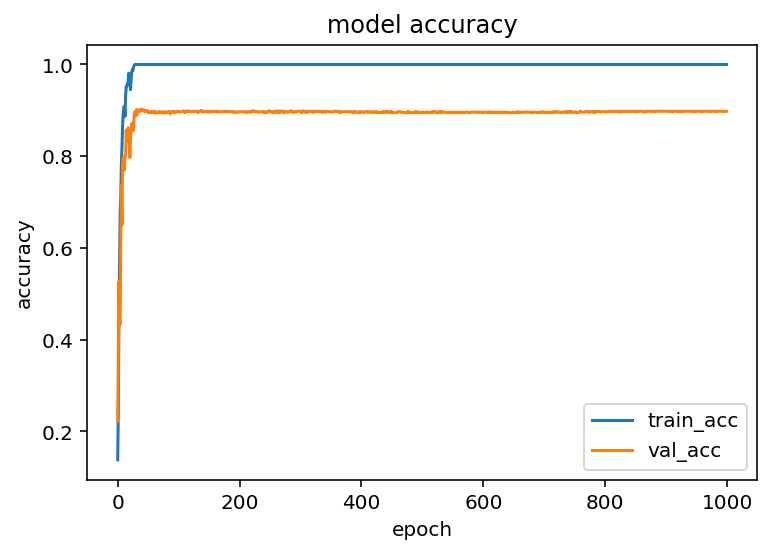

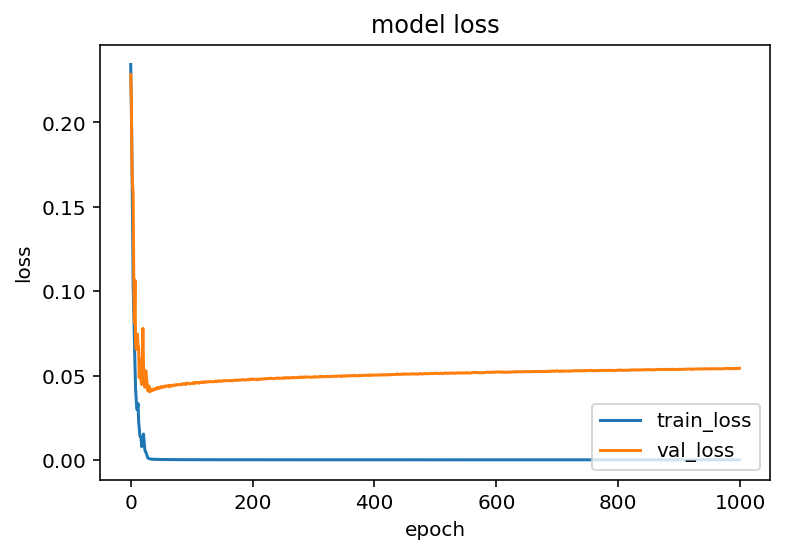

In [17]:
model = Net()
if use_gpu:
    model.cuda()

def save_checkpoint(state, filename='./save/checkpoint_{}.pth'.format(ex_name)):
    torch.save(state, filename)
    #shutil.copyfile(filename, 'model_best.pth.tar')
    
criterion = nn.KLDivLoss()
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum)
tracker = TrainingTracker()

for epoch in range(0, epochs):
    tracker.epoch = epoch
    
    _train(model, train_loader, criterion, optimizer, tracker)
    _validate(model, val_loader, criterion, tracker)
    
    # if latest accuracy is the best in history
    if np.argmax(tracker.history['val_acc']) == len(tracker.history['val_acc']) - 1:
        save_checkpoint({
            'epoch': epoch,
            'state_dict': model.state_dict(),
            'optimizer' : optimizer.state_dict(),
        })
    
logger.info('Train done.')
tracker.plot_history()

# Make Pseudo Label

In [14]:
model = Net()
resume = torch.load('./save/checkpoint_{}.pth'.format(ex_name))
model.load_state_dict(resume['state_dict'])
_test(model, test_loader, criterion, make_pl=True)

100%|██████████| 266/266 [00:16<00:00, 16.43it/s]
[2017-12-02 17:49:32,844 INFO] TestAcc: 0.9045 | TestLoss: 0.0309 


In [18]:
model = Net()
resume = torch.load('./save/checkpoint_{}.pth'.format(ex_name))
model.load_state_dict(resume['state_dict'])
_test(model, test_loader, criterion, make_pl=True)

100%|██████████| 266/266 [00:13<00:00, 20.20it/s]
[2017-12-02 18:19:04,253 INFO] TestAcc: 0.8952 | TestLoss: 0.0376 
